In [1]:
import numpy as np
import networkx as nx
import netrd
import matplotlib.pyplot as plt
import itertools as it

plt.rc('axes', axisbelow=True)
%matplotlib inline

# 0.2.2: Welcome to `netrd`!
## This notebook will detail the main tools and functionality of `netrd`

Created by Brennan Klein: October 28, 2020. For questions, comments, concerns, and more, reach out at 

    brennanjamesklein at gmail dot com


### Other resources:
- __[Visit the github](https://github.com/netsiphd/netrd)__
- __[Visit the ReadTheDocs](https://netrd.readthedocs.io/en/latest/)__

Complex systems throughout nature and society are often best represented as *networks*. Over the last two decades, alongside the increased availability of large network datasets, we have witnessed the rapid rise of network science. This field is built around the idea that an increased understanding of the complex structural properties of different systems will allow us to better observe, predict, and even control the behavior of these systems. However, for many systems, the "network" is not data that we readily have access to. More and more, we see the drive to study networks that have been inferred or reconstructed from non-network data---in particular, from *time series* data. Selecting the most appropriate technique for doing this remains a challenging problem in network science. One option is to try out several techniques and compare the resulting networks, although herein lies another open and challenging problem in network science: can do we *quantify* the difference between pairs of networks, and what are the best techniques for doing so?

# Reconstructing networks from time series data
To illustrate the functionality of the `netrd.reconstruction` submodule, we first simulate time series data from an underlying "ground truth" network.

In [2]:
# dictionary of some example dynamics to play around with
dynamics = {'BranchingModel':              netrd.dynamics.BranchingModel(),
            'IsingGlauber':                netrd.dynamics.IsingGlauber(),
            'SherringtonKirkpatrickIsing': netrd.dynamics.SherringtonKirkpatrickIsing(),
            'VoterModel':                  netrd.dynamics.VoterModel()}

In [3]:
# select network for testing
G0 = nx.ring_of_cliques(4, 16)

# get average degree of the network
k_avg = np.mean(list(dict(G0.degree()).values()))

dyna_name = 'SherringtonKirkpatrickIsing'
# select the dynamical process you want to simulate on the network
D0 = dynamics[dyna_name]

# how long should the time series be?
L  = 2001

# simulate D0 dynamics on the network
TS = D0.simulate(G0, L)

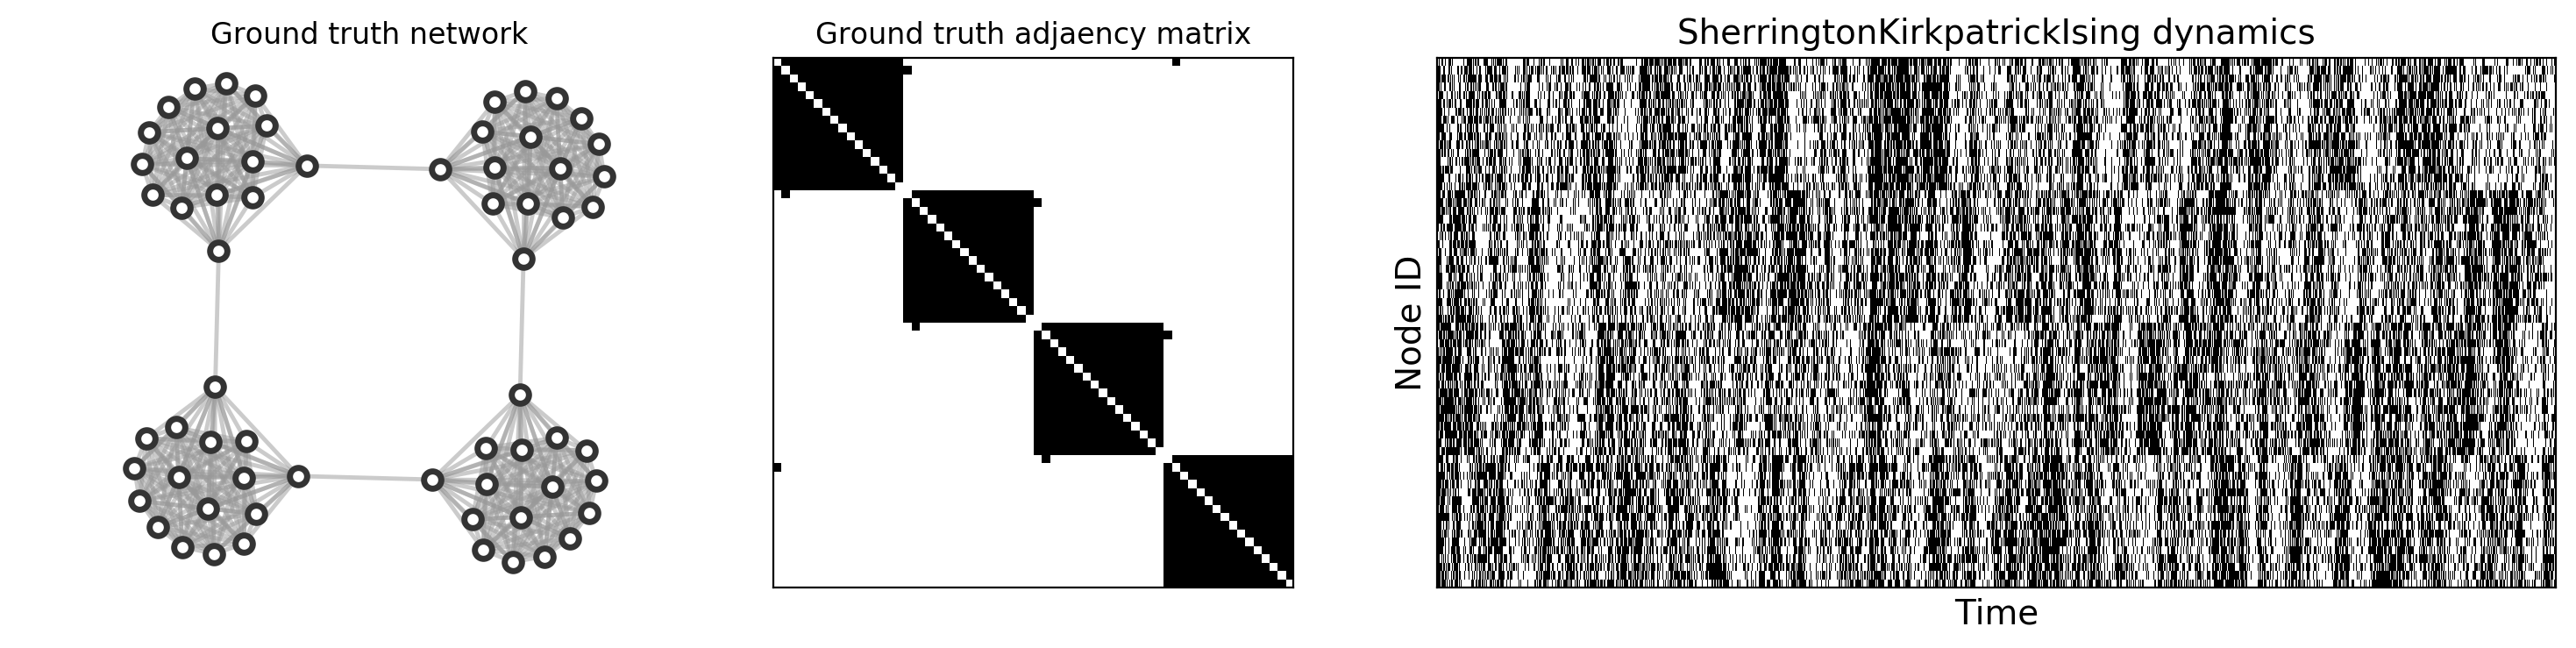

In [4]:
fig, ax = plt.subplots(1,3,figsize=(18,4),gridspec_kw={'width_ratios':[1,1,2.15]},dpi=200)

pos = nx.kamada_kawai_layout(G0)

nx.draw_networkx_nodes(G0, pos, node_size=50, node_color='w', linewidths=2.5, edgecolors='.2', ax=ax[0])
nx.draw_networkx_edges(G0, pos, width=1.75, edge_color='.6', alpha=0.5, ax=ax[0])
ax[0].set_title("Ground truth network")
ax[0].set_axis_off()

ax[1].imshow(nx.to_numpy_array(G0), cmap='Greys', aspect='auto')
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_title("Ground truth adjaency matrix")

ax[2].imshow(TS, cmap='Greys', aspect='auto')
ax[2].set_yticks([])
ax[2].set_xlabel("Time", size=14)
ax[2].set_ylabel("Node ID", size=14)
ax[2].set_title("%s dynamics"%dyna_name, size=14)


plt.show()

### Using the time series above (right), we want to reconstruct the adjacency matrix (middle)

In [5]:
# dictionary of some of the reconstruction techniques in netrd
# (leaving out some of the more computationally expensive ones)
recons = {
    'ConvergentCrossMapping':       netrd.reconstruction.ConvergentCrossMapping(),
    'CorrelationMatrix':            netrd.reconstruction.CorrelationMatrix(),
    'ExactMeanField':               netrd.reconstruction.MeanField(),
    'FreeEnergyMinimization':       netrd.reconstruction.FreeEnergyMinimization(),
    'GraphicalLasso':               netrd.reconstruction.GraphicalLasso(),
    'MarchenkoPastur':              netrd.reconstruction.MarchenkoPastur(),
    'MaximumLikelihoodEstimation':  netrd.reconstruction.MaximumLikelihoodEstimation(),
    'MutualInformationMatrix':      netrd.reconstruction.MutualInformationMatrix(),
    'OUInference':                  netrd.reconstruction.OUInference(),
    'ThoulessAndersonPalmer':       netrd.reconstruction.ThoulessAndersonPalmer()}

In [6]:
# for ease of visualization, we'll threshold all the reconstructions 
kwargs = {'threshold_type':'degree', 'avg_k':k_avg}

# dictionary to store the outputs
Wdict = {}

# loop over all the reconstruction techniques
for ri, R1 in list(recons.items()):
    R1.fit(TS, **kwargs)
    Wr = R1.results['thresholded_matrix']
    Wdict[ri] = Wr

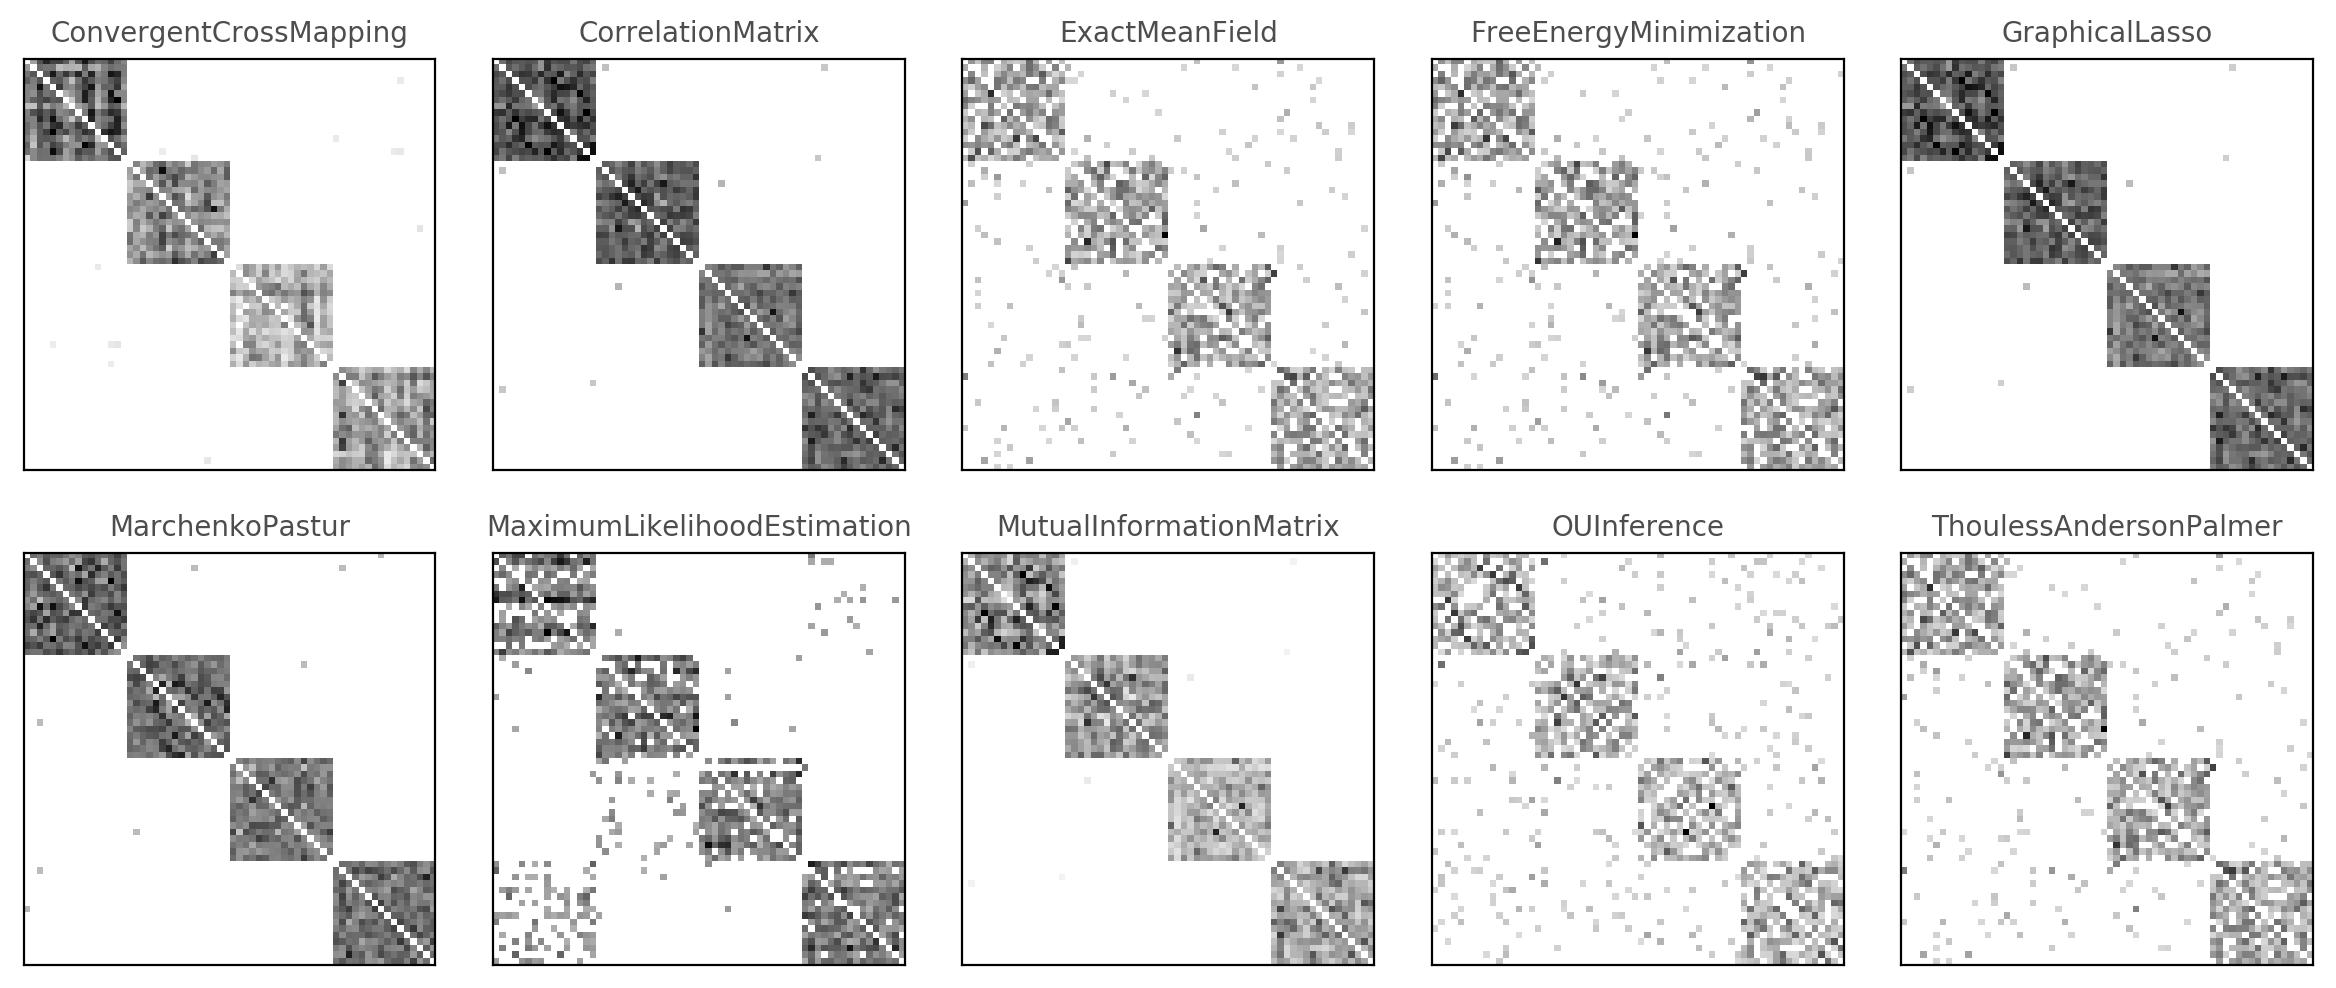

In [7]:
w = 3.0; h = 3.0
ncols = 5; nrows = 2
tups = list(it.product(range(nrows), range(ncols)))

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=200)
plt.subplots_adjust(wspace=0.05,hspace=0.2)

ix = 0
for lab_i, W_i in Wdict.items():
    a = ax[tups[ix]]
    a.imshow(W_i, cmap='Greys')
    ix += 1
    a.set_title(lab_i, color='.3', fontsize='medium')
    a.set_yticks([])
    a.set_xticks([])

plt.show()

**Key takeaways:** Each of these techniques is able to reconstruct the original network relatively well. This is also a simple network to reconstruct. Using different underlying network structures and different dynamics, we start to see much more variability in the effectiveness and consistency of these tools.

_____________

# Quantifying the difference between two graphs with graph distances
To illustrate the functionality of the `netrd.distance` submodule, we measure the distance between two networks under several different techniques.

In [8]:
# (make two example networks)
G1 = nx.random_geometric_graph(55, 0.25)
G2 = nx.random_geometric_graph(55, 0.25)

In [9]:
# dictionary of some of the graph distance measures in netrd
# (leaving out some of the more computationally expensive ones)
distances = {
    'Jaccard':                 netrd.distance.JaccardDistance(),
    'Hamming':                 netrd.distance.Hamming(),
    'HammingIpsenMikhailov':   netrd.distance.HammingIpsenMikhailov(),
    'Frobenius':               netrd.distance.Frobenius(),
    'PolynomialDissimilarity': netrd.distance.PolynomialDissimilarity(),
    'DegreeDivergence':        netrd.distance.DegreeDivergence(),
    'PortraitDivergence':      netrd.distance.PortraitDivergence(),
    'QuantumJSD':              netrd.distance.QuantumJSD(),
    'CommunicabilityJSD':      netrd.distance.CommunicabilityJSD(),
    'GraphDiffusion':          netrd.distance.GraphDiffusion(),
    'ResistancePerturbation':  netrd.distance.ResistancePerturbation(),
    'NetLSD':                  netrd.distance.NetLSD(),
    'IpsenMikhailov':          netrd.distance.IpsenMikhailov(),
    'NonBacktrackingSpectral': netrd.distance.NonBacktrackingSpectral(),
    'DistributionalNBD':       netrd.distance.DistributionalNBD(),
    'DMeasure':                netrd.distance.DMeasure(),
    'DeltaCon':                netrd.distance.DeltaCon(),
    'NetSimile':               netrd.distance.NetSimile()}

In [10]:
# dictionary to store the outputs
dists = {}

# loop over all the reconstruction techniques
for d_lab, d_i in distances.items():
    dists[d_lab] = d_i.dist(G1,G2)

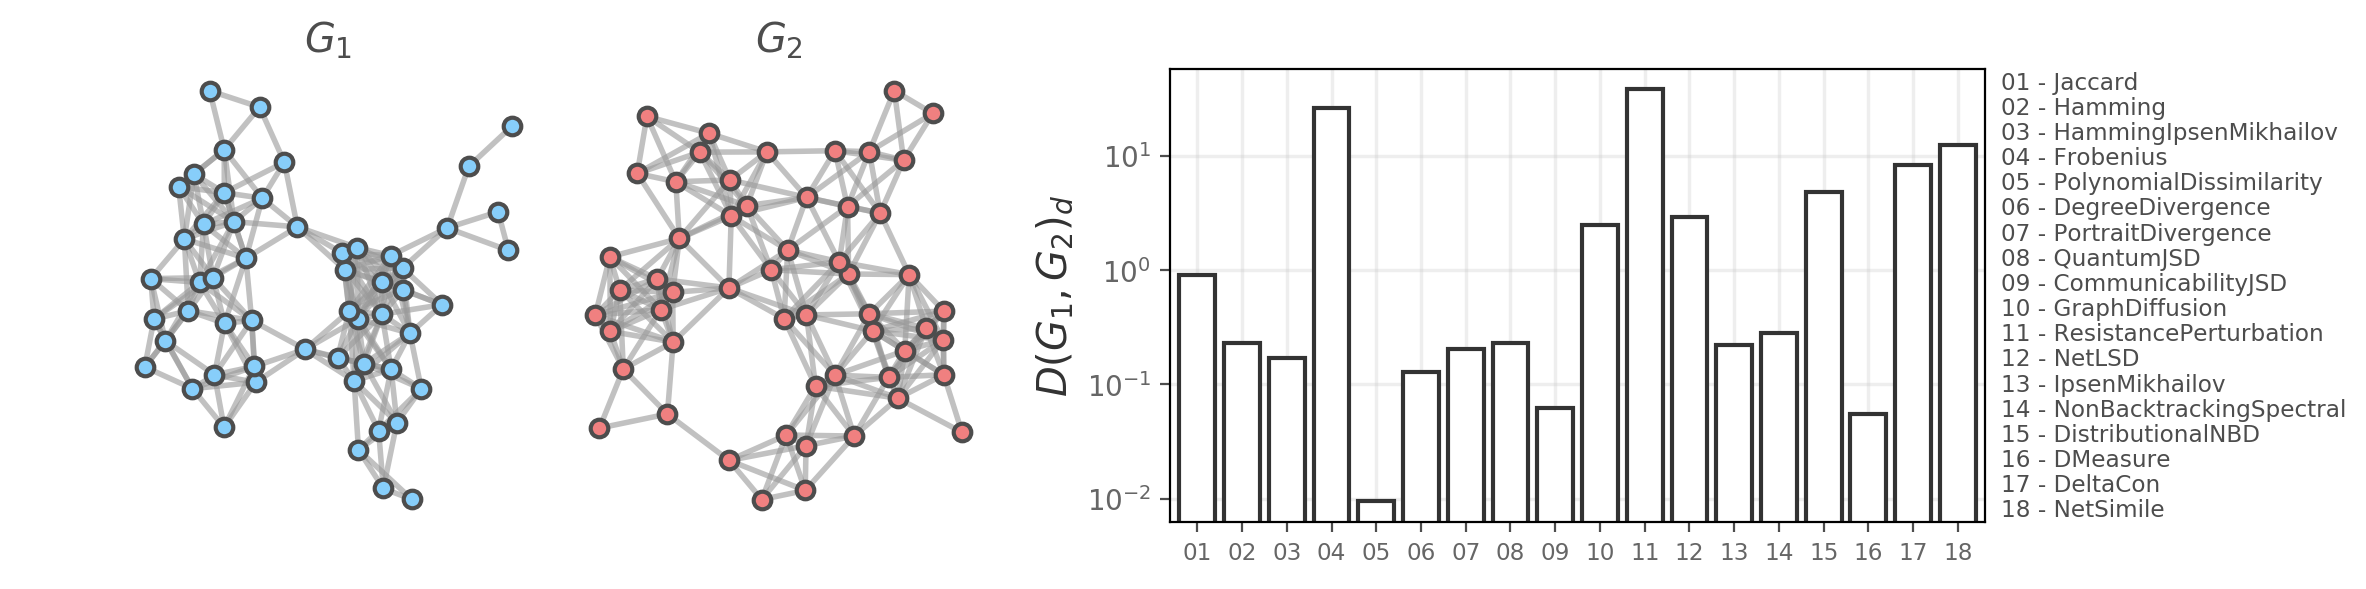

In [11]:
fig, ax = plt.subplots(1,4,figsize=(12,3),dpi=200,gridspec_kw={'width_ratios':[1,1,0.25,2.0]})
plt.subplots_adjust(wspace=0.1)

pos1 = nx.kamada_kawai_layout(G1)
pos2 = nx.kamada_kawai_layout(G2)

nx.draw_networkx_nodes(G1, pos1, node_size=40, linewidths=1.5, edgecolors='.3',
                       node_color='lightskyblue', ax=ax[0])
nx.draw_networkx_edges(G1, pos1, width=2, alpha=0.6, edge_color='.6', ax=ax[0])
ax[0].set_title(r'$G_1$',fontsize='x-large',color='.3')
ax[0].set_axis_off()

nx.draw_networkx_nodes(G2, pos2, node_size=40, linewidths=1.5, edgecolors='.3',
                       node_color='lightcoral', ax=ax[1])
nx.draw_networkx_edges(G2, pos2, width=2, alpha=0.6, edge_color='.6', ax=ax[1])
ax[1].set_title(r'$G_2$',fontsize='x-large',color='.3')
ax[1].set_axis_off()

ax[2].set_axis_off()

ax[3].bar(x=list(range(len(dists))), height=list(dists.values()), fc='w', ec='.2', lw=1.5)
ax[3].set_xticks(list(range(len(dists))))
ax[3].set_xticklabels(["%02i"%(i+1) for i in list(range(len(dists)))],fontsize='small')
ax[3].set_xlim(-0.6,len(distances)-0.4)
ax[3].set_yscale('log')
ax[3].set_ylabel(r'$D(G_1, G_2)_d$', fontsize='x-large', color='.2')
ax[3].tick_params(labelbottom=True, bottom=True, labelleft=True, left=True, labelcolor='.4', color='.3')
ax[3].grid(linewidth=1.25,color='.75',alpha=0.25)
for i, title_i in enumerate(list(distances.keys())):
    lab_i = "%02i - %s"%(i+1,title_i)
    ax[3].text(1.02, 1-(i/len(distances))-0.55/len(distances), lab_i, ha='left', va='center',
               color='.3', transform=ax[3].transAxes, fontsize='small')


plt.show()

_____________

Know of any techniques that we should/could add to improve `netrd`? Feel free to open an issue and let us know! https://github.com/netsiphd/netrd/